<a href="https://colab.research.google.com/github/seanzhu815/business-forecasting/blob/main/405_assignment2_past_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Part1

##1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as skSFS
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error
import warnings
import seaborn as sns


Mounted at /content/drive/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import warnings

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/inflation.xlsx",0)

In [ ]:
df_1999=df.iloc[:492,:]
df_1999.index=pd.to_datetime(df_1999['Date'],format='%Y%m',errors='coerce')
sns.lineplot(data=df_1999,x='Date',y='CPILFESL')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
df_1999

In [ ]:
mom_train=df_1999.iloc[:-123,1]
mom_test=df_1999.iloc[-123:,1]

In [ ]:
mom_model=SARIMAX(mom_train, trend='c',order=(1,0,0)).fit()
mom_model.summary()

In [ ]:
mom_fit=pd.DataFrame(mom_model.predict()).reset_index()
train_mom_fitted=pd.concat([mom_train.reset_index(), mom_fit], axis=1)
train_mom_fitted.index= pd.to_datetime(mom_train.reset_index()['Date'], format='%Y-%m-%d', errors='coerce')
train_mom_fitted.drop(['Date','index'],axis=1,inplace=True)
train_mom_fitted

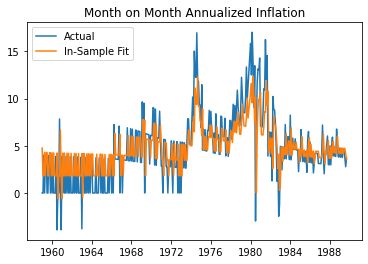

In [ ]:
plt.plot(train_mom_fitted['CPILFESL'],label='Actual')
plt.plot(train_mom_fitted['predicted_mean'],label='In-Sample Fit')
plt.title('Month on Month Annualized Inflation')
plt.legend()

In [ ]:
import itertools

In [ ]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order, cannot be 0.    p = range(0,ar)
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        try:
            mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    return ans_df

In [ ]:
df_1999_train=df_1999['CPILFESL']
AIC_cpi = AIC_PDQ(df_1999_train,3,1,2)

In [ ]:
minIndices = max(AIC_cpi.apply(lambda x:(np.argmin(x)),0))
print(f'The order for best AIC = {AIC_cpi.iloc[minIndices,0]} for Inflation ')

The order for best AIC = (1, 0, 1) for Inflation 


In [ ]:
model_cpi=ARIMA(df_1999_train,order=(1,0,1),trend='c',enforce_stationarity=True,
enforce_invertibility=True)
fit_cpi=model_cpi.fit()
res_cpi = fit_cpi.resid

In [ ]:
from statsmodels.stats import diagnostic as diag
def box_test(df,l):
    print(f'At lag of {l}')
    print(f'X-squared = {round(sm.stats.acorr_ljungbox(df, lags=[l], return_df=True, boxpierce=True).iloc[0,0],4)}')
    print(f'p-values = {round(sm.stats.acorr_ljungbox(df, lags=[l], return_df=True, boxpierce=True).iloc[0,1],4)}\n')
    return round(sm.stats.acorr_ljungbox(df, lags=[l], return_df=True, boxpierce=True).iloc[0,0],4),round(sm.stats.acorr_ljungbox(df, lags=[l], return_df=True, boxpierce=True).iloc[0,1],4)

In [ ]:
box_test(res_cpi,1)
box_test(res_cpi,10)

In [ ]:
fitted_cpi = pd.DataFrame(df_1999_train)
fitted_cpi['predicted'] = fit_cpi.predict()
fitted_cpi.columns = ['actual','predicted']
fitted_cpi=fitted_cpi.reset_index().melt(id_vars='Date')

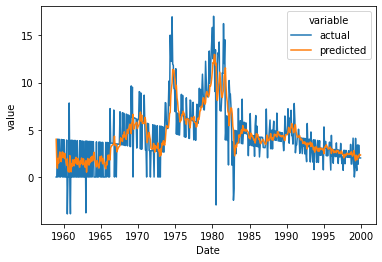

In [ ]:
sns.lineplot(data=fitted_cpi,x='Date',y='value',hue='variable')

We fail to reject the null hypothesis of no serial correlation for the model. 

In [ ]:
fit_cpi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               CPILFESL   No. Observations:                  492
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1096.979
Date:                Tue, 18 Oct 2022   AIC                           2201.958
Time:                        03:01:32   BIC                           2218.752
Sample:                    01-01-1959   HQIC                          2208.553
                         - 12-01-1999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0014      1.111      3.603      0.000       1.825       6.178
ar.L1          0.9774      0.009    114.092      0.000       0.961       0.994
ma.L1         -0.7490      0.027    -27.948      0.000      -0.801      -0.696
sigma2         5.0469      0.205     24.560      0.000       4.644       5.450
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               442.73
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 2

In [ ]:
def forward_stepwise_selection(input_data,to_predict,k,cc,return_features=True):
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    param_list=[]
    predict_is=[]
    predict_oos=[]
    rmse_train=[]
    rmse_test=[]
    r_squared=[]
    const_list=['const']
    lr = LinearRegression()  #Linear regression function
    for i in range(start,len(X)):
      x_new = X.loc[:start-1,]
      y_new = Y[:start]
      sfs = SFS(lr, k_features=k, #stepwise selection 
                    forward=True, 
                    scoring='neg_mean_squared_error',
                    cv=0)
      sfs = sfs.fit(x_new, y_new) # fit the stepwise model
      x_train=sm.add_constant(x_new[np.array(sfs.subsets_[k]['feature_names']).tolist()])
      reg=sm.OLS(y_new,x_train).fit()
      prediction_train=reg.predict(sm.add_constant(x_new[np.array(sfs.subsets_[k]['feature_names']).tolist()]))
      predict_is.append(prediction_train)
      x_test=pd.DataFrame(X.loc[i]).T
      prediction_test=reg.predict(sm.add_constant(x_test[const_list+np.array(sfs.subsets_[k]['feature_names']).tolist()]))
      predict_oos.append(prediction_test)
      param_list.append(np.array(np.array(sfs.subsets_[k]['feature_names']).tolist()))
      rmse_train.append(mean_squared_error(y_new, prediction_train))
      r_squared.append(r2_score(y_new, prediction_train))
      rmse_train.append(mean_squared_error(y_new, prediction_train))
      start = i
      x_new = x_new.append(pd.DataFrame(X.loc[start]).T)
      y_new = y_new.append(pd.Series(Y[start]))
    rmse_test.append(mean_squared_error(to_predict[cc:], predict_oos))    
    
    if return_features:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos, param_list
    else:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos

def backward_stepwise_selection(input_data,to_predict,k,cc,return_features=True):
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    param_list=[]
    predict_is=[]
    predict_oos=[]
    rmse_train=[]
    rmse_test=[]
    r_squared=[]
    const_list=['0']
    lr = LinearRegression()  #Linear regression function
    for i in range(start,len(X)):
        sfs = SFS(lr, k_features=k, #stepwise selection 
              forward=False, 
              scoring='neg_mean_squared_error',
              cv=0)
        sfs = sfs.fit(x_new.values, y_new.values)
        names_list=const_list+np.array(sfs.subsets_[k]['feature_names']).tolist()
        names=list(map(int, names_list))
        x_train = x_new.iloc[:,names]
        reg=sm.OLS(y_new,x_train).fit()
        prediction_train=reg.predict(x_train)
        predict_is.append(prediction_train)
        x_test=pd.DataFrame(input_data.loc[i]).T
        prediction_test=reg.predict(x_test.iloc[:,names])
        predict_oos.append(prediction_test)
        param_list.append(np.array(np.array(sfs.subsets_[k]['feature_names']).tolist()))
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        start = i
        x_new = x_new.append(pd.DataFrame(X.loc[start]).T)
        y_new = y_new.append(pd.Series(Y[start]))
        y_new=y_new.reset_index(drop=True)

    rmse_test.append(mean_squared_error(to_predict[cc:], predict_oos))    
    
    if return_features:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos, param_list
    else:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos

In [ ]:
df1 = pd.read_excel("/content/drive/MyDrive/inflation.xlsx",0)
date = pd.to_datetime(df1['Date'], format='%Y%m', errors='coerce')
df1.drop('Date', axis=1, inplace=True)

In [ ]:
X = df1.loc[398:492].reset_index(drop=True)
Y = df1.loc[398:492,'CPILFESL'].reset_index(drop=True)
X.drop(['CPILFESL'],axis=1,inplace=True)
X=sm.add_constant(X)
date=date[398:492]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
X


,const,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,1.0,0.001653,0.000812,0.001824,0.004017,-0.003001,0.008279,0.008512,0.008994,0.009106,...,0.001266,-0.000199,0.000836,0.011670,-0.003556,7.2,-0.016313,0.001663,-0.003653,16.2227
1,1.0,0.003730,0.002751,0.000839,0.006642,0.006017,0.007593,0.007433,0.007599,0.009344,...,-0.002156,0.000777,0.000830,-0.005836,0.001759,1.2,0.037147,-0.005843,0.001010,16.1885
2,1.0,0.005329,0.005493,0.005146,-0.008738,0.005467,0.003221,0.005498,0.005804,0.006482,...,0.000976,-0.002553,-0.002514,-0.000726,-0.000890,2.0,-0.052941,0.000207,0.004327,14.7280
3,1.0,0.004173,0.004447,0.002696,0.010487,0.002804,0.000539,-0.002438,-0.003092,-0.004904,...,0.003189,0.000237,0.002500,0.007957,-0.000883,1.2,0.045621,0.008812,-0.001184,14.7531
4,1.0,-0.000796,-0.001346,0.003342,0.013303,0.007080,0.008911,0.009982,0.011293,0.012977,...,-0.002334,0.002648,-0.004169,-0.015187,-0.000003,-3.8,-0.003523,-0.008544,0.002648,13.3036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,1.0,-0.000399,-0.000359,0.005007,-0.001815,0.004168,-0.004220,-0.005361,-0.007374,-0.007842,...,0.003549,0.001476,0.004721,0.005336,0.001426,2.7,-0.060199,-0.002851,-0.000489,26.0494
91,1.0,0.006031,0.006649,0.002197,0.008748,0.001915,0.012894,0.013504,0.015008,0.019292,...,-0.006847,-0.000417,-0.004053,-0.000022,-0.003580,-4.0,0.032110,-0.004752,0.002066,25.3700
92,1.0,0.006911,0.008011,0.004905,0.005156,0.011948,0.005209,0.001109,-0.000693,-0.000714,...,-0.002364,-0.000343,-0.000002,-0.004720,0.001429,4.0,0.005214,0.002042,-0.011789,22.2295
93,1.0,0.008174,0.008851,0.011899,0.004322,0.018317,0.007834,0.008984,0.009121,0.010821,...,0.007839,-0.000327,0.002007,0.004112,0.002134,-1.8,0.012954,0.000935,0.017419,23.2213


In [ ]:
train_X = X[:345]
train_Y = Y[:345]
train_date=date[:345]
val_X = X[345:394]
val_Y = Y[345:394]
val_date=date[345:395]
test_X = X[395:]
test_Y = Y[395:]
test_date=date[395:]
train_val_X=X[:394]
train_val_Y=Y[:394]

In [ ]:
def MSE(actual, pred):
    sse = [(a-p)**2 for a,p in zip(actual,pred)]
    return(np.mean(sse))

In [ ]:
f_rmse_train,f_rmse_test, f_r_squared, f_predict_is, f_predict_oos, f_param_list=forward_stepwise_selection(X,Y,3,94)
b_rmse_train,b_rmse_test, b_r_squared, b_predict_is, b_predict_oos, b_param_list=backward_stepwise_selection(X,Y,3,94)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
f_param_list

[array(['PERMITW', 'CPIAPPSL', 'CUSR0000SAS'], dtype='<U11')]

In [ ]:
b_param_list

[array(['35', '53', '111'], dtype='<U3')]

In [ ]:
a=int(b_param_list[0][0])
b=int(b_param_list[0][1])
c=int(b_param_list[0][2])

In [ ]:
print(X.columns[[a,b,c]])

Index(['USCONS', 'PERMIT', 'CUSR0000SAS'], dtype='object')


#Part3

## 1

In [ ]:
df2=pd.read_excel("/content/drive/MyDrive/retail_sales.xlsx",index_col=0)

In [ ]:
df2

,Sales
Date,
1992-01-31,131.204025
1992-02-29,131.175693
1992-03-31,142.694460
1992-04-30,147.143808
1992-05-31,152.437230
...,...
2022-04-30,595.550142
2022-05-31,611.322169
2022-06-30,610.107900


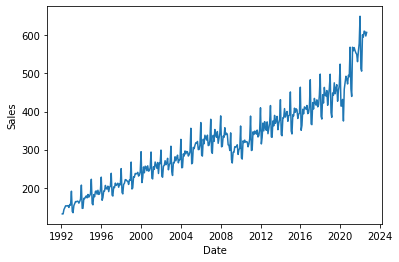

In [ ]:
sns.lineplot(data=df2,x='Date',y='Sales')

## 3

In [ ]:
df2['sales_mom'] = np.log(df2['Sales']).diff()*12
df2['sales_yoy'] = np.log(df2['Sales']).diff(12)

Text(0.5, 1.0, 'Core Inflation Year on Year Annualized')

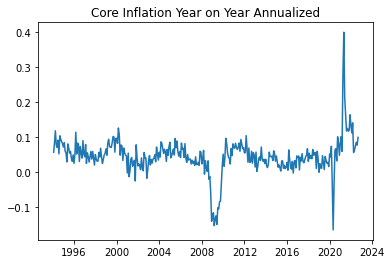

In [ ]:
plt.plot(df2['sales_yoy'])
plt.title('Core Inflation Year on Year Annualized')

In [ ]:
df2.dropna(inplace=True)

In [ ]:
mom_train=df2.iloc[:-56,1]
mom_test=df2.iloc[-56:,1]
yoy_train=df2.iloc[:-56,2]
yoy_test=df2.iloc[-56:,2]

In [ ]:
mom_train

Date
1994-01-31   -4.201287
1994-02-28    0.026905
1994-03-31    1.966311
1994-04-30   -0.061043
1994-05-31    0.304608
                ...   
2017-08-31    0.392787
2017-09-30   -0.523643
2017-10-31    0.141389
2017-11-30    0.730638
2017-12-31    1.400929
Name: sales_mom, Length: 288, dtype: float64

In [ ]:
mom_model=SARIMAX(mom_train, trend='c',order=(1,0,0)).fit()
yoy_model=SARIMAX(yoy_train, trend='c',order=(1,0,0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [ ]:
mom_model.summary()
yoy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              sales_yoy   No. Observations:                  288
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 643.432
Date:                Tue, 18 Oct 2022   AIC                          -1280.863
Time:                        06:01:27   BIC                          -1269.874
Sample:                    01-31-1994   HQIC                         -1276.459
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.002      5.020      0.000       0.005       0.012
ar.L1          0.7865      0.029     26.982      0.000       0.729       0.844
sigma2         0.0007   4.88e-05     13.717      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  23.04   Jarque-Bera (JB):                 8.15
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.62   Skew:                            -0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
mom_fit=pd.DataFrame(mom_model.predict()).reset_index()
yoy_fit=pd.DataFrame(yoy_model.predict()).reset_index()

train_mom_fitted=pd.concat([mom_train.reset_index(), mom_fit], axis=1)
train_mom_fitted.index= pd.to_datetime(mom_train.reset_index()['Date'], format='%Y-%m-%d', errors='coerce')

train_yoy_fitted=pd.concat([yoy_train.reset_index(), yoy_fit], axis=1)
train_yoy_fitted.index= pd.to_datetime(yoy_train.reset_index()['Date'], format='%Y-%m-%d', errors='coerce')

train_mom_fitted.drop(['Date','index'],axis=1,inplace=True)
train_yoy_fitted.drop(['Date','index'],axis=1,inplace=True)

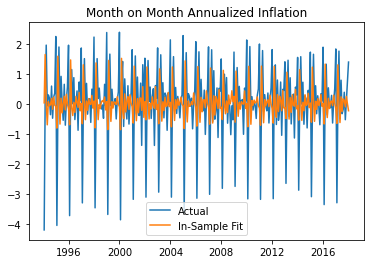

In [ ]:
plt.plot(train_mom_fitted['sales_mom'],label='Actual')
plt.plot(train_mom_fitted['predicted_mean'],label='In-Sample Fit')
plt.title('Month on Month Annualized Inflation')
plt.legend()

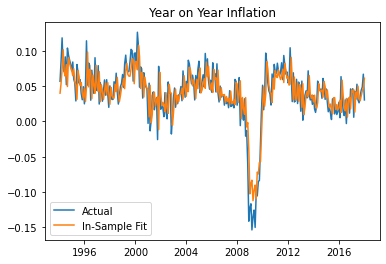

In [ ]:
plt.plot(train_yoy_fitted['sales_yoy'],label='Actual')
plt.plot(train_yoy_fitted['predicted_mean'],label='In-Sample Fit')
plt.title('Year on Year Inflation')
plt.legend()

In [ ]:
mom_forecasts=mom_model.forecast(56)
mom_forecasts.index=pd.to_datetime(mom_test.reset_index()['Date'])

yoy_forecasts=yoy_model.forecast(56)
yoy_forecasts.index=pd.to_datetime(yoy_test.reset_index()['Date'])

mom_test =pd.concat([mom_test, mom_forecasts], axis=1)
yoy_test =pd.concat([yoy_test, yoy_forecasts], axis=1)

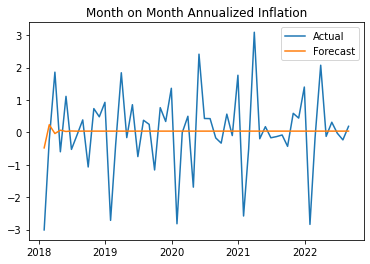

In [ ]:
plt.plot(mom_test['sales_mom'],label='Actual')
plt.plot(mom_test['predicted_mean'],label='Forecast')
plt.title('Month on Month Annualized Inflation')
plt.legend()

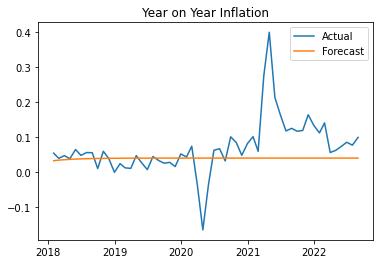

In [ ]:
plt.plot(yoy_test['sales_yoy'],label='Actual')
plt.plot(yoy_test['predicted_mean'],label='Forecast')
plt.title('Year on Year Inflation')
plt.legend()

## another model

In [ ]:
df2_2017=df2.iloc[:312,]
df2_2017

,Sales
Date,
1992-01-31,131.204025
1992-02-29,131.175693
1992-03-31,142.694460
1992-04-30,147.143808
1992-05-31,152.437230
...,...
2017-08-31,430.775462
2017-09-30,412.381985
2017-10-31,417.269568


In [ ]:
df2_2017

,Sales,DSales
Date,,
1992-01-31,131.204025,NaN
1992-02-29,131.175693,-0.000216
1992-03-31,142.694460,0.084168
1992-04-30,147.143808,0.030705
1992-05-31,152.437230,0.035343
...,...,...
2017-08-31,430.775462,0.032732
2017-09-30,412.381985,-0.043637
2017-10-31,417.269568,0.011782


In [ ]:
def adf_test(timeseries, reg):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression=reg, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
adf_test(df2_2017['Sales'], 'c'),adf_test(df2_2017['DSales'].iloc[1:], 'c') 

Results of Dickey-Fuller Test:
Test Statistic                  -0.396696
p-value                          0.910649
#Lags Used                      15.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -3.342153
p-value                          0.013096
#Lags Used                      14.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


(None, None)

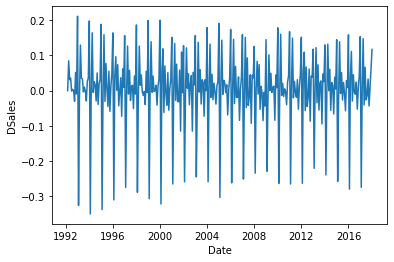

In [ ]:
sns.lineplot(data=df2_2017,x='Date',y='DSales')

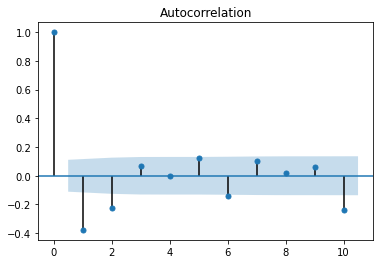

In [ ]:
sm.graphics.tsa.plot_acf(df2_2017['DSales'].iloc[1:,], lags=10);

In [ ]:
box_test(df2_2017['DSales'],1)
box_test(df2_2017['DSales'],10)

At lag of 1
X-squared = 44.7447
p-values = 0.0

At lag of 10
X-squared = 96.1513
p-values = 0.0



(96.1513, 0.0)

In [ ]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order, cannot be 0.    p = range(0,ar)
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        try:
            mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    return ans_df

In [ ]:
AIC_sales = AIC_PDQ(mom_train,6,1,3)

In [ ]:
minIndices = max(AIC_sales.apply(lambda x:(np.argmin(x)),0))
print(f'The order for best AIC = {AIC_sales.iloc[minIndices,0]} for Inflation ')

The order for best AIC = (4, 0, 2) for Inflation 


In [ ]:
model_sales=ARIMA(mom_train,order=(4,0,2),trend='c',enforce_stationarity=True,
enforce_invertibility=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [ ]:
fit_sales=model_sales.fit()
res_sales = fit_sales.resid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
box_test(res_sales,1)
box_test(res_sales,10)

At lag of 1
X-squared = 0.0667
p-values = 0.7961

At lag of 10
X-squared = 42.9989
p-values = 0.0



(42.9989, 0.0)

We fail to reject the null hypothesis of no serial correlation for the model except for serial correlation at the 10th lag of the inflation model.

In [ ]:
fitted_sales = pd.DataFrame(mom_train)
fitted_sales['predicted'] = fit_sales.predict()
fitted_sales.columns = ['actual','predicted']
fitted_sales

,actual,predicted
Date,,
1994-01-31,-4.201287,0.039402
1994-02-28,0.026905,1.657769
1994-03-31,1.966311,1.885368
1994-04-30,-0.061043,0.393503
1994-05-31,0.304608,-0.534879
...,...,...
2017-08-31,0.392787,0.183961
2017-09-30,-0.523643,-0.391492
2017-10-31,0.141389,0.420709


In [ ]:
fitted_sales=fitted_sales.reset_index().melt(id_vars='Date')

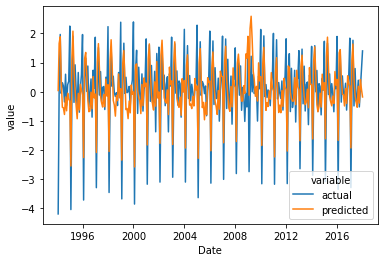

In [ ]:
sns.lineplot(data=fitted_sales,x='Date',y='value',hue='variable')

In [ ]:
mom_forecasts=fit_sales.forecast(56)

mom_test =pd.concat([mom_test, mom_forecasts], axis=1)
mom_test

,sales_mom,predicted_mean,predicted_mean,predicted_mean
2018-01-31,-3.012245,-1.924713,-1.924713,-1.924713
2018-02-28,-0.232519,-0.000247,-0.000247,-0.000247
2018-03-31,1.860194,0.296545,0.296545,0.296545
2018-04-30,-0.599097,0.530633,0.530633,0.530633
2018-05-31,1.113142,-0.436528,-0.436528,-0.436528
2018-06-30,-0.525336,0.228810,0.228810,0.228810
2018-07-31,-0.075702,-0.189796,-0.189796,-0.189796
2018-08-31,0.385937,0.373433,0.373433,0.373433
2018-09-30,-1.068094,-0.266777,-0.266777,-0.266777
2018-10-31,0.735202,0.308732,0.308732,0.308732


In [ ]:

mom_test=mom_test.iloc[:,:2]
mom_test

,sales_mom,predicted_mean
2018-01-31,-3.012245,-1.924713
2018-02-28,-0.232519,-0.000247
2018-03-31,1.860194,0.296545
2018-04-30,-0.599097,0.530633
2018-05-31,1.113142,-0.436528
2018-06-30,-0.525336,0.228810
2018-07-31,-0.075702,-0.189796
2018-08-31,0.385937,0.373433
2018-09-30,-1.068094,-0.266777
2018-10-31,0.735202,0.308732


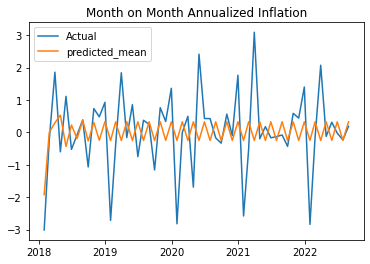

In [ ]:
plt.plot(mom_test['sales_mom'],label='Actual')
plt.plot(mom_test['predicted_mean'],label='predicted_mean')
plt.title('Month on Month Annualized Inflation')
plt.legend()